In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Optional
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Get data into dataframe
df = pd.read_csv('WMA_fractions_v2.csv', skiprows=1)

# Preprocess data to only have temperature, salinity and dissolved oxygen
df_TSO = df.copy()
df_TSO = df_TSO[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]', 'Latitude_[deg_N]', 'Longitude_[deg_E]']]
df_TSO = df_TSO.dropna()

In [3]:
def uniform_geographic_sample(
    df: pd.DataFrame,
    n_samples: int,
    lat_col: str = 'latitude',
    lon_col: str = 'longitude',
    n_grid_cells: int = 50,
    random_state: Optional[int] = None) -> pd.DataFrame:
    """
    Sample points from a dataset to minimize spatial density variability.
    
    Uses grid-based stratified sampling to ensure uniform geographic coverage.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with geographic coordinates
    n_samples : int
        Number of samples to draw
    lat_col : str
        Name of the latitude column
    lon_col : str
        Name of the longitude column
    n_grid_cells : int
        Number of grid cells per dimension (creates n_grid_cells x n_grid_cells grid)
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    pd.DataFrame
        Sampled dataframe with uniform spatial distribution
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    df = df.copy()
    
    # Get coordinate bounds
    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()
    
    # Create grid cells
    lat_bins = np.linspace(lat_min, lat_max, n_grid_cells + 1)
    lon_bins = np.linspace(lon_min, lon_max, n_grid_cells + 1)
    
    # Assign each point to a grid cell
    df['_lat_bin'] = pd.cut(df[lat_col], bins=lat_bins, labels=False, include_lowest=True)
    df['_lon_bin'] = pd.cut(df[lon_col], bins=lon_bins, labels=False, include_lowest=True)
    df['_grid_cell'] = df['_lat_bin'].astype(str) + '_' + df['_lon_bin'].astype(str)
    
    # Count points per grid cell
    cell_counts = df['_grid_cell'].value_counts()
    occupied_cells = len(cell_counts)
    
    # Calculate target samples per cell for uniform distribution
    samples_per_cell = n_samples / occupied_cells
    
    # Strategy: Sample equally from each occupied cell for uniform coverage
    # First pass: try to take equal samples from each cell
    base_samples_per_cell = n_samples // occupied_cells
    extra_samples = n_samples % occupied_cells
    
    sampled_dfs = []
    cells_to_boost = []
    
    for i, cell_id in enumerate(cell_counts.index):
        cell_df = df[df['_grid_cell'] == cell_id]
        
        # Base samples for this cell
        n_from_cell = base_samples_per_cell
        
        # Distribute extra samples to first few cells
        if i < extra_samples:
            n_from_cell += 1
        
        # Can't sample more than available in cell
        n_from_cell = min(n_from_cell, len(cell_df))
        
        if n_from_cell > 0:
            sampled = cell_df.sample(n=n_from_cell, replace=False)
            sampled_dfs.append(sampled)
        
        # Track if this cell couldn't provide enough samples
        if n_from_cell < base_samples_per_cell + (1 if i < extra_samples else 0):
            deficit = (base_samples_per_cell + (1 if i < extra_samples else 0)) - n_from_cell
            cells_to_boost.append(deficit)
    
    # Combine all samples
    result = pd.concat(sampled_dfs, ignore_index=True)
    
    # If we have a deficit, sample more from cells that have remaining points
    if len(result) < n_samples:
        remaining_df = df[~df.index.isin(result.index)]
        if len(remaining_df) > 0:
            additional_needed = n_samples - len(result)
            additional = remaining_df.sample(n=min(additional_needed, len(remaining_df)), replace=False)
            result = pd.concat([result, additional], ignore_index=True)
    
    # Remove helper columns
    result = result.drop(columns=['_lat_bin', '_lon_bin', '_grid_cell'])
    
    return result

In [4]:
df_sampled = uniform_geographic_sample(df_TSO, n_samples=100000, lat_col='Latitude_[deg_N]', lon_col='Longitude_[deg_E]', n_grid_cells=100, random_state=22)

In [5]:
# Compute data centroid (mean location)
# center_lat = df_TSO['Latitude_[deg_N]'].mean()
# center_lon = df_TSO['Longitude_[deg_E]'].mean()
center_lat = df_sampled['Latitude_[deg_N]'].mean()
center_lon = df_sampled['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_sampled,
    lat='Latitude_[deg_N]',
    lon='Longitude_[deg_E]',
    title="Sampled data in geographic space"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()

Center lat: 79.81604592 Center lon: -50.949791180000005


In [6]:
# Extract values into a tensor
X = torch.tensor(df_sampled.values, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# Define Variational Autoencoder

class VAE(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 16)
        self.fc3 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)     # no sigmoid for real-valued data

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
# Define loss function (mse and KL divergence)
def vae_loss(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE(input_dim=5, latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in loader:
        x = batch[0].to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataset):.4f}")

Epoch 1 | Loss: 13398.7176
Epoch 2 | Loss: 588.2333
Epoch 3 | Loss: 306.5179
Epoch 4 | Loss: 225.9697
Epoch 5 | Loss: 187.9695
Epoch 6 | Loss: 164.9631
Epoch 7 | Loss: 145.8780
Epoch 8 | Loss: 123.4097
Epoch 9 | Loss: 102.9199
Epoch 10 | Loss: 92.9337
Epoch 11 | Loss: 86.9200
Epoch 12 | Loss: 82.9035
Epoch 13 | Loss: 81.4551
Epoch 14 | Loss: 79.8168
Epoch 15 | Loss: 78.2955
Epoch 16 | Loss: 79.2092
Epoch 17 | Loss: 77.8462
Epoch 18 | Loss: 76.3842
Epoch 19 | Loss: 76.0599
Epoch 20 | Loss: 75.1699
Epoch 21 | Loss: 75.2044
Epoch 22 | Loss: 75.0934
Epoch 23 | Loss: 74.1435
Epoch 24 | Loss: 74.2358
Epoch 25 | Loss: 74.1234
Epoch 26 | Loss: 74.4346
Epoch 27 | Loss: 72.9334
Epoch 28 | Loss: 73.3700
Epoch 29 | Loss: 72.8263
Epoch 30 | Loss: 73.8494
Epoch 31 | Loss: 72.2694
Epoch 32 | Loss: 73.9264
Epoch 33 | Loss: 71.4041
Epoch 34 | Loss: 72.4450
Epoch 35 | Loss: 71.8438
Epoch 36 | Loss: 71.7546
Epoch 37 | Loss: 72.6480
Epoch 38 | Loss: 71.6110
Epoch 39 | Loss: 71.3497
Epoch 40 | Loss: 71.277

In [10]:
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X.to(device))
    z = mu.cpu()   # latent representation

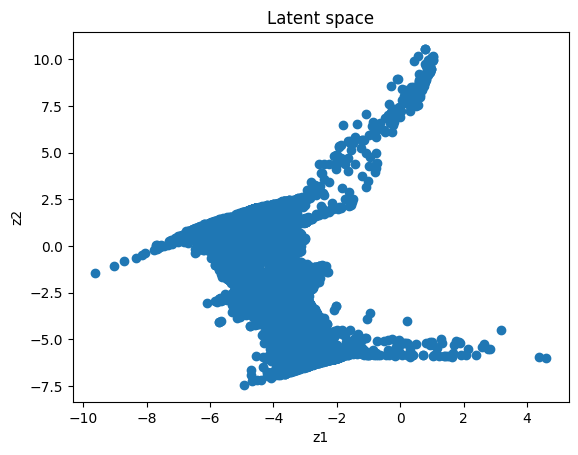

In [11]:
plt.scatter(z[:,0].cpu().tolist(), z[:,1].cpu().tolist())
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Latent space")
plt.show()

from Medium
## AIC
AIC (Akaike Information Criterion) rewards models that fit the data well while penalizing unnecessary complexity. AIC is more forgiving, often favoring slightly more complex models. It’s commonly used when we want to avoid underfitting, and is preferred for smaller datasets.

$AIC = -2 \ln(\text{Likelihood}) + 2k$

## BIC
BIC (Bayesian Information Criterion) also penalizes complexity but is stricter, especially for large datasets. BIC is stricter, especially as the dataset grows. It tends to favor simpler models, as the penalty for extra parameters increases with sample size.
    
$BIC = -2 \ln(\text{Likelihood}) + k \ln(n)$

https://medium.com/@jshaik2452/choosing-the-best-model-a-friendly-guide-to-aic-and-bic-af220b33255f

Choice of scores also from https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_gaussian_model_selection.html

## Log Likelihood

Used in Maximum Likelihood Estimation (Goodness of fit test)

https://medium.com/@gopal.sukumar/aic-bic-penalties-and-the-science-behind-model-selection-bd0d4d06d335

In [32]:
from sklearn.mixture import GaussianMixture 
# Do BIC and AIC calculation for different number of clusters
bic_scores = []
aic_scores = []
ll_scores = []
n_components_range = range(1, 12)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=22)
    gmm.fit(z.cpu().numpy())
    bic_scores.append(gmm.bic(z.cpu().numpy()))
    aic_scores.append(gmm.aic(z.cpu().numpy()))
    ll_scores.append(gmm.score(z.cpu().numpy()))

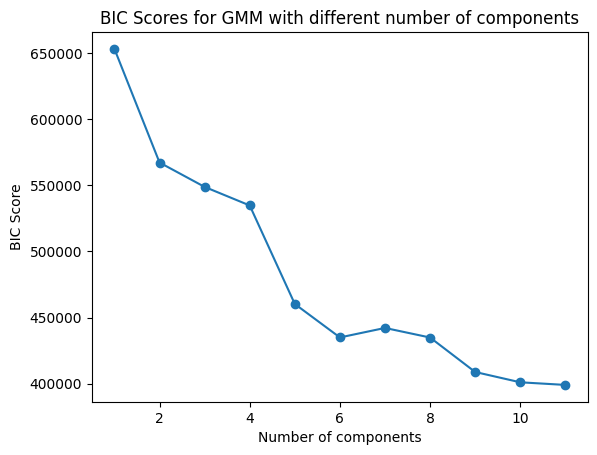

In [33]:
# BIC score plot
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel("Number of components")  
plt.ylabel("BIC Score")
plt.title("BIC Scores for GMM with different number of components")
plt.show()

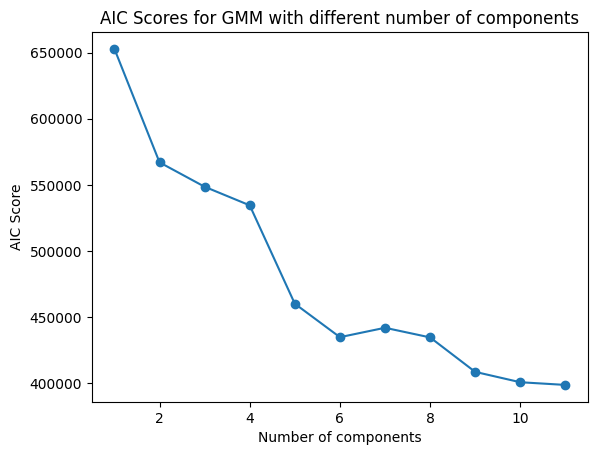

In [34]:
# AIC score plot
plt.plot(n_components_range, aic_scores, marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC Score")
plt.title("AIC Scores for GMM with different number of components")
plt.show()

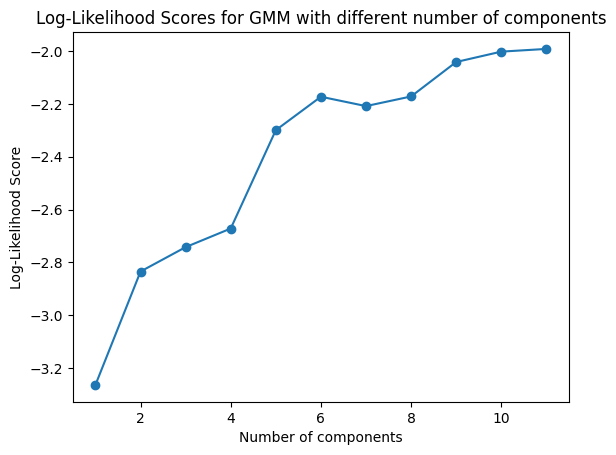

In [35]:
# Log-Likelihood score plot
plt.plot(n_components_range, ll_scores, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Log-Likelihood Score")
plt.title("Log-Likelihood Scores for GMM with different number of components")
plt.show()

In [36]:
with torch.no_grad():
    recon = model(X.to(device))[0].cpu().numpy()

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=22)
gmm.fit(z)
gmm_labels = gmm.predict(z)
df_sampled['gmm_label'] = gmm_labels.astype(int)

/Users/franciscagomes/PhD/WM_class/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




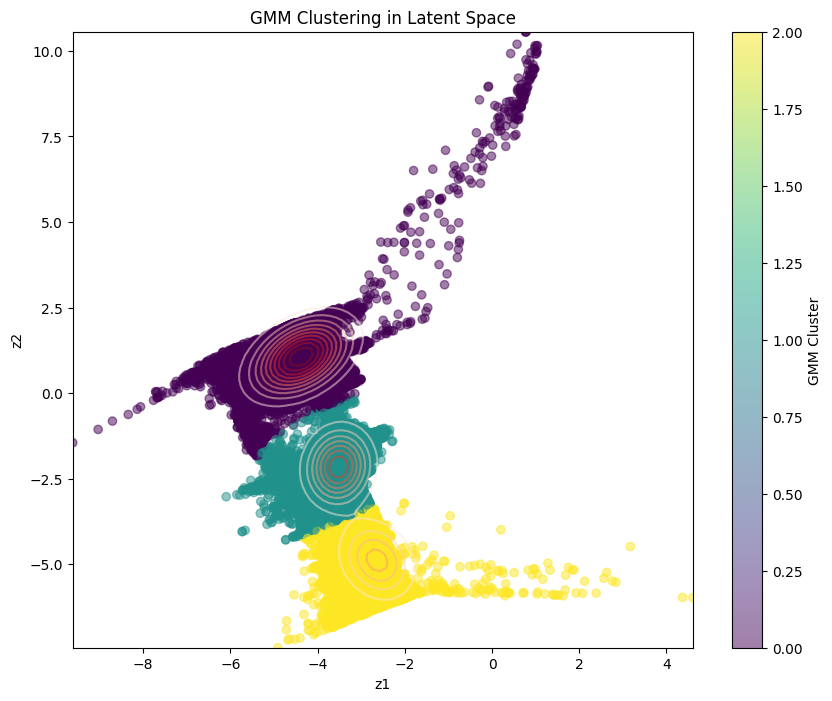

In [19]:
# Plot GMM on latent space with probability contours for each cluster
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(z[:,0].cpu().tolist(), z[:,1].cpu().tolist(), c=gmm_labels, cmap='viridis', alpha=0.5)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("GMM Clustering in Latent Space")
plt.colorbar(scatter, label='GMM Cluster')
# Plot contours
x = np.linspace(z[:,0].min().cpu(), z[:,0].max().cpu(), 100)
y = np.linspace(z[:,1].min().cpu(), z[:,1].max().cpu(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))
Z = np.exp(gmm.score_samples(pos.reshape(-1, 2))).reshape(X_grid.shape)
ax.contour(X_grid, Y_grid, Z, levels=10, cmap='Reds', alpha=0.5)
plt.show()


In [14]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(df_sampled['Longitude_[deg_E]'], df_sampled['Latitude_[deg_N]'], c=df_sampled['gmm_label'], s=5)
# plt.colorbar(label="GMM cluster")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("GMM clustering shown in geographical space")
# plt.show()

In [15]:
# Compute data centroid (mean location)
center_lat = df_sampled['Latitude_[deg_N]'].mean()
center_lon = df_sampled['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_sampled,
    lat='Latitude_[deg_N]',
    lon='Longitude_[deg_E]',
    color='gmm_label',
    title="Gaussian Mixture Model on VAE latent space projected on geographic map"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()

Center lat: 79.81604592 Center lon: -50.949791180000005


In [37]:
gmm6 = GaussianMixture(n_components=6, random_state=22)
gmm6.fit(z)
gmm6_labels = gmm6.predict(z)
df_sampled['gmm_label_6'] = gmm6_labels.astype(int)

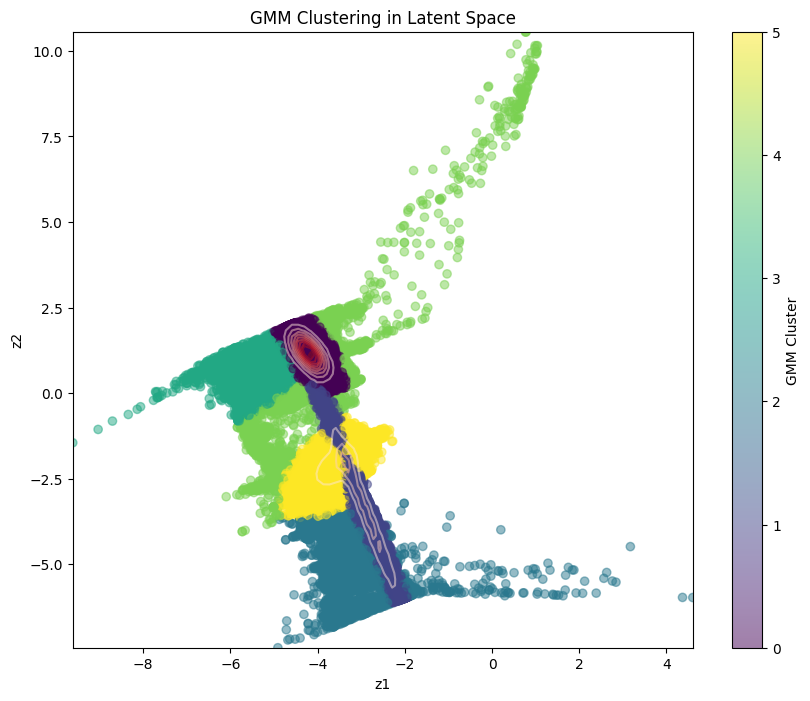

In [38]:
# Plot GMM on latent space with probability contours for each cluster
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(z[:,0].cpu().tolist(), z[:,1].cpu().tolist(), c=gmm6_labels, cmap='viridis', alpha=0.5)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("GMM Clustering in Latent Space")
plt.colorbar(scatter, label='GMM Cluster')

# Plot contours
x = np.linspace(z[:,0].min().cpu(), z[:,0].max().cpu(), 100)
y = np.linspace(z[:,1].min().cpu(), z[:,1].max().cpu(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))
Z = np.exp(gmm6.score_samples(pos.reshape(-1, 2))).reshape(X_grid.shape)
ax.contour(X_grid, Y_grid, Z, levels=10, cmap='Reds', alpha=0.5)
plt.show()


In [40]:
# Compute data centroid (mean location)
center_lat = df_sampled['Latitude_[deg_N]'].mean()
center_lon = df_sampled['Longitude_[deg_E]'].mean()

print("Center lat:", center_lat, "Center lon:", center_lon)

# Use labels from kmeans clustering on data to plot geographically
fig3 = px.scatter_geo(
    df_sampled,
    lat='Latitude_[deg_N]',
    lon='Longitude_[deg_E]',
    color='gmm_label_6',
    title="Gaussian Mixture Model on VAE latent space projected on geographic map"
)

fig3.update_geos(
    projection_type="orthographic",
    projection_rotation=dict(lat=center_lat, lon=center_lon),
    showcoastlines=True,
    showcountries=True
)

fig3.update_layout(height=800, width=800)
fig3.show()

Center lat: 79.81604592 Center lon: -50.949791180000005
